In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# transform images to the tensors with three color channels and dynamic range of 0 to 255 and scale down between 0 and 1 torchvision.transforms.ToTensor
# Normalize the data with mean 0.5 and standard deviation 0.5 torchvision.transforms.Normalize

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [ ]:
# Download and create training set
trainset = datasets.EMNIST(root="gdrive/MyDrive/Independept_Study_Physics_Informed_Deep_Learning/Letter_rec_EMNIST_TRAIN", split= "letters", download=True, train=True, transform=transform)
# Download and create test set
valset = datasets.EMNIST(root="gdrive/MyDrive/Independept_Study_Physics_Informed_Deep_Learning/Letter_rec_EMNIST_TEST", split="letters", download=True, train=False, transform=transform)
valset.test_labels[:] = valset.test_labels[:]-1
trainset.train_labels[:] = trainset.train_labels[:]-1

# Load train set to DataLoader with batch size of 64
# DataLoader combines data-set and a sampler and provides single or multi process iterators over the data set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# Load test set to DataLoader
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
# check image and label tensors size
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print('batch size, image pixels =',images.shape)
print('labels shape =', labels.shape)
print(min(labels))
print(max(labels))

<class 'torch.Tensor'>
batch size, image pixels = torch.Size([64, 1, 28, 28])
labels shape = torch.Size([64])
tensor(0)
tensor(25)


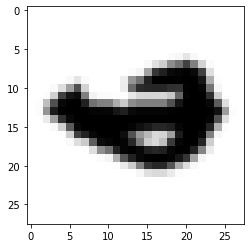

In [ ]:
# Display a image from training data set
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

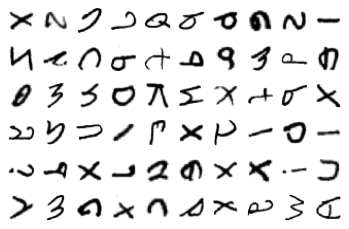

In [ ]:
# Display 60 images from training data set in a grid and in a random order
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
input_size = 784
hidden_sizes = [128, 128, 128, 64]
output_size = 26

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[3], output_size),
                      nn.LogSoftmax(dim=1))
print(model)
# output layer uses LogSoftmax activation function (classification problem)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=26, bias=True)
  (9): LogSoftmax(dim=1)
)


In [ ]:
# activating GPU (if any)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=26, bias=True)
  (9): LogSoftmax(dim=1)
)

In [ ]:
criterion = nn.NLLLoss()  # negative log-likelihood loss functions is used
#images, labels = next(iter(trainloader))  # iter call __iter__() onthe trainloader returning an iterator, next call __next__() method to get the next batches
print(images.shape)
print(criterion)
images = images.view(images.shape[0], -1) # view changes the view of the data, in this case it changes the shape of the images (flattening out the images)
print(images.shape)
print(labels.shape)
logps = model(images.cuda()) #log probabilities
loss = criterion(logps, labels.cuda()) #calculate the NLL loss


torch.Size([64, 1, 28, 28])
NLLLoss()
torch.Size([64, 784])
torch.Size([64])


In [ ]:
# import optimizer
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

In [ ]:
# training process

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 30
print(images.shape)
print(labels)
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        # Training pass
        optimizer.zero_grad()

        output = model(images.cuda())
        loss = criterion(output, labels.cuda())

        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

torch.Size([64, 784])
tensor([ 3, 23, 18, 20,  9, 16, 15,  1,  4, 18, 11, 25,  7,  2, 15,  5,  3,  0,
        22, 16,  4, 14, 22, 13,  3, 10, 12, 23,  5, 15, 23, 24, 21, 20, 11,  4,
        23,  9, 11, 14,  8,  9,  3, 23,  9, 20,  4, 23, 23,  8, 20, 24, 22,  2,
        23,  2,  1, 23,  6, 22,  0, 13,  9, 13])
Epoch 0 - Training loss: 2.1354562094578378
Epoch 1 - Training loss: 0.7728896334538093
Epoch 2 - Training loss: 0.5320248759098543
Epoch 3 - Training loss: 0.43419005766893043
Epoch 4 - Training loss: 0.37560882759399905
Epoch 5 - Training loss: 0.3390188356508047
Epoch 6 - Training loss: 0.3107792934202231
Epoch 7 - Training loss: 0.2902975990069218
Epoch 8 - Training loss: 0.2706490369293934
Epoch 9 - Training loss: 0.25846460689527867
Epoch 10 - Training loss: 0.24448266500081772
Epoch 11 - Training loss: 0.23482393875336036
Epoch 12 - Training loss: 0.2237166444498759
Epoch 13 - Training loss: 0.21591258980906927
Epoch 14 - Training loss: 0.20846596013277005
Epoch 15 - Traini

In [ ]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()
    alphabet = ('A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z')

    y_pos = np.arange(len(alphabet))
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(y_pos, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(alphabet)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Letter = 23


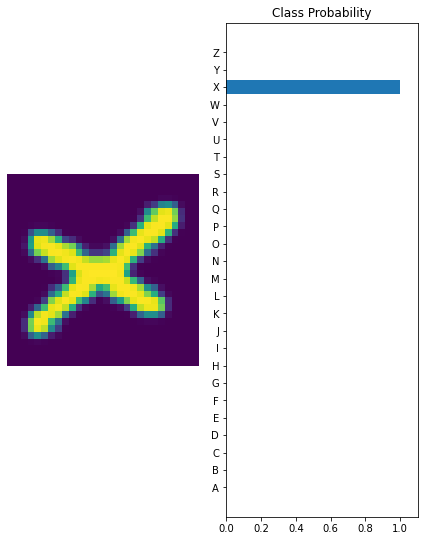

In [ ]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img.cuda())

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Letter =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [ ]:
# iterate the trained model through the validation data and calculate the total number of correct predictions
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img.cuda())

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 20800

Model Accuracy = 0.9128365384615384


In [ ]:
# save the model
torch.save(model, 'gdrive/MyDrive/Independept_Study_Physics_Informed_Deep_Learning/Digit_rec_MNIST/my_mnist_model.pt')